# 🎬 Trening modelu rekomendacyjnego NeuMF + gatunek (MovieLens)
W tym notebooku budujemy system rekomendacyjny oparty na architekturze NeuMF (Neural Matrix Factorization) z dodatkowymi embeddingami gatunków filmowych.

Celem modelu jest przewidywanie ocen użytkowników dla filmów na podstawie danych MovieLens. 1M


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
import pickle

## 📥 Wczytanie danych MovieLens

Na początek wczytujemy pliki `ratings.dat` oraz `movies.dat` ze zbioru MovieLens.  
Dane te zawierają odpowiednio:
- informacje o ocenach (użytkownik, film, ocena, znacznik czasu),
- tytuły filmów wraz z przypisanymi gatunkami.


In [ ]:
ratings = pd.read_csv('ratings.dat', sep='::', engine='python',
                      names=['userId', 'movieId', 'rating', 'timestamp'],
                      encoding='latin1')

movies = pd.read_csv('movies.dat', sep='::', engine='python',
                     names=['movieId', 'title', 'genres'],
                     encoding='latin1')

print(sorted(ratings['rating'].unique()))
ratings.head()


[np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [ ]:
movies['main_genre'] = movies['genres'].str.split('|').str[0]

from sklearn.preprocessing import LabelEncoder
genre_encoder = LabelEncoder()
movies['genre_id'] = genre_encoder.fit_transform(movies['main_genre'])

n_genres = len(genre_encoder.classes_)
print(f"Liczba unikalnych gatunków: {n_genres}")
movies[['title', 'main_genre', 'genre_id']].head()


Liczba unikalnych gatunków: 18


,title,main_genre,genre_id
0,Toy Story (1995),Animation,2
1,Jumanji (1995),Adventure,1
2,Grumpier Old Men (1995),Comedy,4
3,Waiting to Exhale (1995),Comedy,4
4,Father of the Bride Part II (1995),Comedy,4


In [ ]:
print("Unikalnych użytkowników:", ratings['userId'].nunique())
print("Unikalnych filmów:", ratings['movieId'].nunique())
print("Liczb ocen:", len(ratings))


Unikalnych użytkowników: 6040
Unikalnych filmów: 3706
Liczb ocen: 1000209


## 🎯 Filtrowanie filmów ocenionych zbyt rzadko

Wielu filmów nikt prawie nie ocenił – a model nie ma szans nauczyć się ich preferencji.  
Dlatego zachowujemy tylko filmy, które zostały ocenione przez **co najmniej 25 użytkowników**.  
Dzięki temu eliminujemy przypadki, które mogą pogorszyć jakość rekomendacji.


In [ ]:
movie_counts = ratings['movieId'].value_counts()
popular_movies = movie_counts[movie_counts >= 25].index
filtered_ratings = ratings[ratings['movieId'].isin(popular_movies)]


print(f"Filmow po filtracji: {filtered_ratings['movieId'].nunique()}")

Filmow po filtracji: 2934


## 🙋‍♀️ Filtrowanie użytkowników o niskiej aktywności

Użytkownicy, którzy ocenili tylko kilka filmów, nie dostarczają wystarczającej liczby danych, by można było ich profilować.  
Zachowujemy więc tylko tych użytkowników, którzy ocenili **co najmniej 7 filmów**.


In [ ]:
user_counts = filtered_ratings['userId'].value_counts()
active_users = user_counts[user_counts >= 7].index
filtered_ratings = filtered_ratings[filtered_ratings['userId'].isin(active_users)]


In [ ]:
print(f"Zostało ocen: {len(filtered_ratings)}")


Zostało ocen: 993114


## 📊 Rozkład ocen w zbiorze

Przed dalszym przetwarzaniem warto przyjrzeć się rozkładowi ocen.  
Histogram poniżej pokazuje, które oceny są najczęstsze – zwykle dominują wysokie (4 i 5).

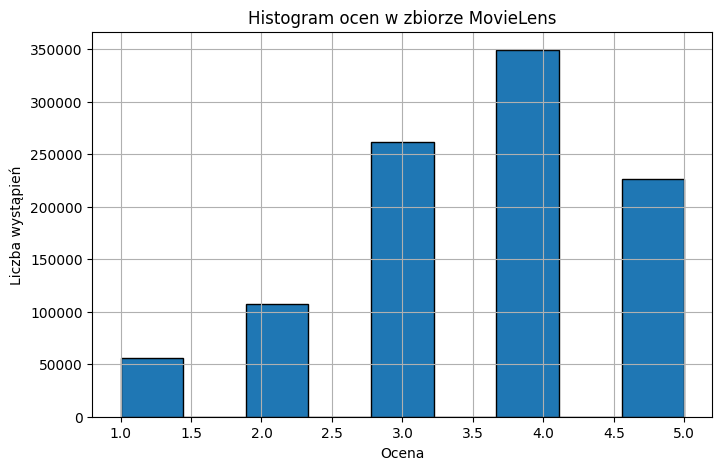

In [ ]:
plt.figure(figsize=(8, 5))
ratings['rating'].hist(bins=9, edgecolor='black')
plt.title('Histogram ocen w zbiorze MovieLens')
plt.xlabel('Ocena')
plt.ylabel('Liczba wystąpień')
plt.grid(True)
plt.show()


## 📊 Finalnie dane wyglądają nastepujaco



In [ ]:
print("Finalne dane:")
print("Użytkownicy:", data['userId'].nunique())
print("Filmy:", data['movieId'].nunique())
print("Oceny:", len(data))


Finalne dane:
Użytkownicy: 5027
Filmy: 2934
Oceny: 843152


In [ ]:
user_ids = data['userId'].astype('category').cat.codes.values
movie_ids = data['movieId'].astype('category').cat.codes.values
genre_ids = data['genre_id'].values
ratings = data['rating'].values



X = np.stack([user_ids, movie_ids, genre_ids], axis=1)
y = ratings


n_users = len(np.unique(X[:, 0]))
n_movies = len(np.unique(X[:, 1]))
n_genres = len(np.unique(X[:, 2]))


In [ ]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
import tensorflow.keras.backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


### 🔧 Model NeuMF z embeddingiem gatunku

Model łączy dwa podejścia:

- **GMF (Generalized Matrix Factorization)** – liniowa interakcja między użytkownikiem a filmem poprzez iloczyn ich embeddingów.
- **MLP (Multilayer Perceptron)** – nieliniowe zależności modelowane przez sieć neuronową z warstwami Dense, ReLU, BatchNormalization i Dropout.

Dodatkowo model uwzględnia **embedding gatunku filmu**, który jest dołączany do połączonego wektora GMF i MLP.

Na końcu warstwa Dense przewiduje ocenę użytkownika dla filmu.


In [ ]:
embedding_size = 32


user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))
genre_input = Input(shape=(1,))

user_emb_gmf = Embedding(n_users, embedding_size)(user_input)
movie_emb_gmf = Embedding(n_movies, embedding_size)(movie_input)
gmf_vector = Multiply()([user_emb_gmf, movie_emb_gmf])
gmf_vector = Flatten()(gmf_vector)

user_emb_mlp = Embedding(n_users, embedding_size)(user_input)
movie_emb_mlp = Embedding(n_movies, embedding_size)(movie_input)
mlp_vector = Concatenate()([user_emb_mlp, movie_emb_mlp])
mlp_vector = Flatten()(mlp_vector)
mlp_vector = Dense(32, activation='relu', kernel_regularizer=l2(1e-6))(mlp_vector)
mlp_vector = BatchNormalization()(mlp_vector)
mlp_vector = Dropout(0.5)(mlp_vector)
mlp_vector = Dense(16, activation='relu', kernel_regularizer=l2(1e-6))(mlp_vector)
mlp_vector = BatchNormalization()(mlp_vector)
mlp_vector = Dropout(0.4)(mlp_vector)


genre_emb = Embedding(n_genres, 8)(genre_input)
genre_emb = Flatten()(genre_emb)

neu_vector = Concatenate()([gmf_vector, mlp_vector, genre_emb])
neu_output = Dense(1)(neu_vector)

model = Model(inputs=[user_input, movie_input, genre_input], outputs=neu_output)
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss=root_mean_squared_error, metrics=['mae'])



In [ ]:
es = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)


In [ ]:
history = model.fit(
    [X_train[:, 0], X_train[:, 1], X_train[:, 2]],
    y_train,
    validation_data=([X_val[:, 0], X_val[:, 1], X_val[:, 2]], y_val),
    epochs=100,
    batch_size=512,
    callbacks=[es],
    verbose=1
)

print("Wytrenowano epok:", len(history.history['loss']))

Epoch 1/100
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 3.6679 - mae: 3.4153 - val_loss: 2.7819 - val_mae: 2.5659
Epoch 2/100
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.4502 - mae: 2.1656 - val_loss: 1.5983 - val_mae: 1.3144
Epoch 3/100
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.4934 - mae: 1.2027 - val_loss: 1.1003 - val_mae: 0.8894
Epoch 4/100
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.1529 - mae: 0.9193 - val_loss: 0.9592 - val_mae: 0.7736
Epoch 5/100
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0306 - mae: 0.8220 - val_loss: 0.9124 - val_mae: 0.7331
Epoch 6/100
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9731 - mae: 0.7761 - val_loss: 0.8902 - val_mae: 0.7129
Epoch 7/100
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.9407 - mae: 0.7487 - val_loss: 0.8772 - val_mae: 0.7006
Epoch 8/100
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.9212 - mae: 0.7334 - val_loss: 0.8704 - val_mae: 0.6945
Epoch 9/100
1054/1054 ━━━━━━━━

4216/4216 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
Validation RMSE: 0.836
Validation MAE: 0.658


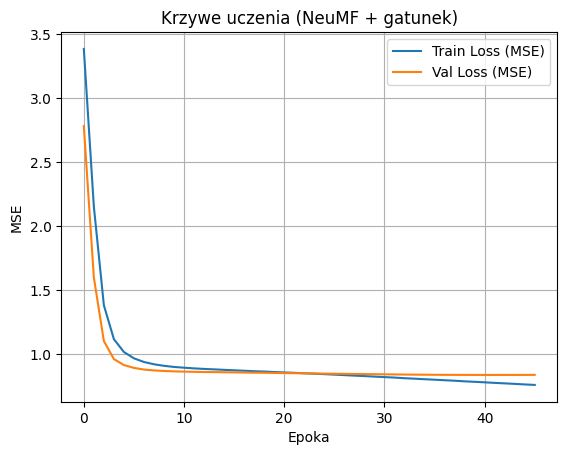

In [ ]:
pred_val = model.predict([X_val[:, 0], X_val[:, 1], X_val[:, 2]]).flatten()
rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))
mae_val = mean_absolute_error(y_val, pred_val)

print(f"Validation RMSE: {rmse_val:.3f}")
print(f"Validation MAE: {mae_val:.3f}")

plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
plt.xlabel("Epoka")
plt.ylabel("MSE")
plt.title("Krzywe uczenia (NeuMF + gatunek)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
pred_test = model.predict([X_test[:, 0], X_test[:, 1], X_test[:, 2]]).flatten()
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
mae_test = mean_absolute_error(y_test, pred_test)

print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test MAE: {mae_test:.3f}")

5270/5270 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Test RMSE: 0.836
Test MAE: 0.660


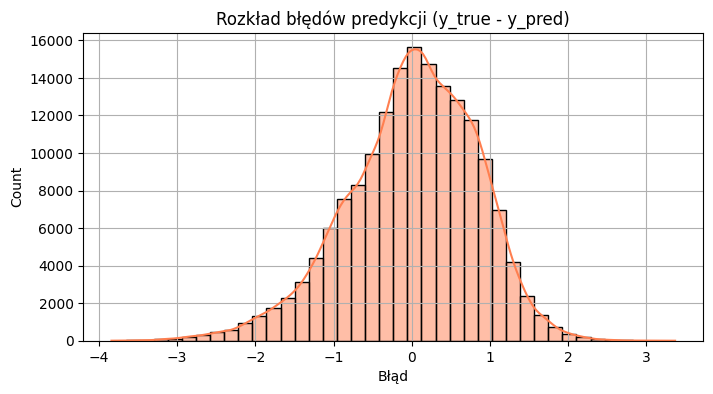

In [ ]:
errors = y_test - pred_test
plt.figure(figsize=(8, 4))
sns.histplot(errors, kde=True, bins=40, color='coral')
plt.title("Rozkład błędów predykcji (y_true - y_pred)")
plt.xlabel("Błąd")
plt.grid(True)
plt.show()


In [ ]:
#zapisanie modelu


model.save("best_model.h5")

In [ ]:

#  Tworzenie mapowań ID
# Mapujemy oryginalne identyfikatory użytkowników, filmów i gatunków
# Zapisujemy także odwrotne mapowania, aby móc potem
# łatwo odkodować wyniki rekomendacji do oryginalnych ID.


user_mapping = {v: i for i, v in enumerate(data['userId'].astype('category').cat.categories)}
movie_mapping = {v: i for i, v in enumerate(data['movieId'].astype('category').cat.categories)}
genre_mapping = {v: i for i, v in enumerate(data['genre_id'].astype('category').cat.categories)}

with open('user2user_encoded.pkl', 'wb') as f:
    pickle.dump(user_mapping, f)
with open('movie2movie_encoded.pkl', 'wb') as f:
    pickle.dump(movie_mapping, f)
with open('genre2genre_encoded.pkl', 'wb') as f:
    pickle.dump(genre_mapping, f)

user_encoded2user = {i: v for v, i in user_mapping.items()}
movie_encoded2movie = {i: v for v, i in movie_mapping.items()}
with open('user_encoded2user.pkl', 'wb') as f:
    pickle.dump(user_encoded2user, f)
with open('movie_encoded2movie.pkl', 'wb') as f:
    pickle.dump(movie_encoded2movie, f)
